In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check countyinfo.csv

In [3]:
region_df = pd.read_excel('/content/drive/MyDrive/traffic_stop/countyinfo.xlsx')
region_df

,county,region
0,Atascosa,Alamo
1,Bandera,Alamo
2,Bexar,Alamo
3,Calhoun,Alamo
4,Comal,Alamo
...,...,...
249,Terrell,West Texas
250,Tom Green,West Texas
251,Upton,West Texas
252,Ward,West Texas


In [12]:
region_df.loc[region_df['county'] == 'Bee',:]

,county,region
153,Bee,South Texas


In [10]:
filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(2007) + '.parquet'
df = pd.read_parquet(filename, engine = 'pyarrow')
df['county'] = [name[:-7] for name in df['county_name']]
df['county'] = df['county'].replace('Dewitt','DeWitt')
df.drop('region', axis = 1, inplace = True)
df = df.join(region_df.set_index('county'), on='county')
df.drop('county', axis = 1, inplace=True)
df.rename(columns={'region':'county_region'}, inplace=True)

df.head()

,raw_row_number,date,time,location,lat,lng,county_name,district,precinct,subject_race,...,vehicle_model,vehicle_type,vehicle_year,raw_HA_RACE_SEX,raw_HA_SEARCH_PC_boolean,raw_HA_SEARCH_CONCENT_boolean,raw_HA_INCIDTO_ARREST_boolean,raw_HA_VEHICLE_INVENT_boolean,year,county_region
2693894,2766545,2007-01-01,00:00:00,"route: 0059, milepost: 698",NaN,NaN,Bee County,A,None,hispanic,...,None,PU,NaN,HM,False,False,False,False,2007,South Texas
2693895,2766546,2007-01-01,00:00:00,"route: 0105, milepost: 442",NaN,NaN,Orange County,B,None,white,...,None,PU,NaN,WM,False,False,False,False,2007,Southeast
2693896,2766547,2007-01-01,00:00:00,"route: 2221, milepost: 508",NaN,NaN,Hidalgo County,A,31,white,...,None,PU,NaN,WM,False,False,False,False,2007,South Texas
2693897,2766548,2007-01-01,00:00:00,"route: 0035, milepost: 176",NaN,NaN,Guadalupe County,B,30,white,...,None,PA,NaN,WF,False,False,False,False,2007,Alamo
2693898,2766549,2007-01-01,00:00:00,"route: 0191, milepost: 258",NaN,NaN,Ector County,A,None,white,...,None,PA,NaN,WF,False,False,False,False,2007,West Texas


In [14]:
sum(df['county_region'].isna())

0

In [16]:
list(region_df['region'].unique())

['Alamo',
 'Capital',
 'Central Texas ',
 'Gulf Coast ',
 'High Plains ',
 'Metroplex ',
 'Northwest ',
 'South Texas ',
 'Southeast ',
 ' Upper East ',
 'UPPER RIO GRANDE',
 'West Texas ']

### Preprocessing Functions

In [4]:
def remove_duplicates(row):
  if row['speeding_only'] == 'speeding-repeated_entries':
    return row['all_violation'][0].strip()
  else:
    return row['violation']

def remove_white_spaces(vio_lst):
  vio_lst = [x.strip() for x in vio_lst]
  return vio_lst


def exclusive(vio_lst):
  count = 0
  for vio in vio_lst:
    # count number of violations containing 'speed'
    if 'speed' in vio:
      count += 1
  # if we have non-speeding violation
  if count < len(vio_lst):
    return 'speeding + others'
  # if we only have speeding violation
  elif count == len(vio_lst):
    # if one speeding vio type
    if count == 1:
      return 'speeding-1'
    # if we have more than one entries but only one type
    elif len(set(vio_lst)) == 1:
      return 'speeding-repeated_entries'
    # if we have more than one type
    else:
      return 'speeding-multiple'
  else:
    return 'undefined case'

In [5]:
def speeding_filter(df):
  print('Before speed filtering: ', len(df))
  df['violation'] = [s.lower() for s in df['violation']]
  # at least one violation is speeding-violated (could have other violations at the same time)
  df = df.loc[df['violation'].str.contains('speed', regex = False),:]
  df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
  df['violation'] = df['violation'].map(lambda x: x.strip())

  # get a list of violations for each record, and apply self-defined func exclusive
  df['all_violation'] = df['violation'].str.split('|')
  df['all_violation'] = df['all_violation'].map(lambda x: remove_white_spaces(x))
  df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))

  # filter out rows with violations other than speeding
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1','speeding-multiple']),:]

  df['violation'] = df.apply(lambda row: remove_duplicates(row), axis = 1)

  df.drop(['all_violation','speeding_only'], axis = 1, inplace = True)
  print('Speeding only violation has records: ', len(df))
  return df

In [6]:
# this function is called by preprocess
def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']
	df = df[df[colName].notna()]
	return(df)

In [7]:
# columns we need in the analysis
keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'citation_issued',
            ]

# delete rows with missing value in these columns
rm_na_col = ['county_name','violation','subject_race','subject_sex']

In [8]:
### this function used in run_year_analysis()
def preprocess(year, rm_na_col, analysis_type,
               violation_types=None, border_counties=None, county_type=None, speeding_only=False, county_region=None):
  """
  with_vio: if include vioation type variables: True, if not include, False
  violation_types: violation types to be included in the analysis
  """
  # read dataframe
  # CHANGED 2023/07/12, why file_path: '/content/drive/MyDrive/traffic_stop/year_data_daylight/'???
  filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  if violation_types:
    filename = '/content/drive/MyDrive/traffic_stop/year_data_speeding_only/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  print('# of all traffic stops in year ', year, ': ', len(df))

  # invalid value (IF NOT TEXAS STATE DATA, DELETE THIS INVALID VALUE BLOCK)
  if year == 2013:
    df.drop(df.index[df['lat'] == 74.052879], inplace=True)

  # based on analysis types, decide which columns to keep
  if analysis_type == 'citation':
    keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'citation_issued',
            ]
  elif analysis_type == 'search':
    keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'search_conducted'
            ]
  elif analysis_type == 'contraband':
    keep_col = [
            'county_name',
            'subject_race',
            'subject_sex',
            'violation',
            'search_conducted',
            'contraband_found',
            ]

  # drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)
    # newly added 2023/07/12
    print('# of traffic stops after preprocessing step 0 - drop na/unknown in COL [',col,']: ',len(df))

  # if we want to only include certain violation types:
  if violation_types:
    print('Including only serious violations')
    #df['violation'] = df['violation'].map(lambda x: x.replace(' (#)', '').strip())
    df = df.loc[df['violation'].isin(violation_types),:]
    print(len(df))

  # filter rows if speeding_only
  if speeding_only:
    # filter: only speeding violation (no other violations)
    df = speeding_filter(df)

  ######### THIS WHOLE BLOACK NEEDS TO BE CHANGED, NEW METROPOLITAN FILES AND DIFFERENT DATA FORMAT #########

  # County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/content/drive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county'] = [name[:-7] for name in df['county_name']]
  df['county'] = df['county'].replace('Dewitt','DeWitt')

  # if we want to include only border counties:
  if border_counties:
    print('Including only border counties')
    df = df.loc[df['county'].isin(border_counties),:]

  df = df.join(county_df.set_index('County Name'), on='county')
  #df.drop('county', axis = 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)

  if county_type:
    print('Including only a certain type of county')
    df = df.loc[df['county_type'] == county_type,:]
    df.drop(['county_type'], axis = 1, inplace = True)

  # newly added 2023/07/12
  print('# of traffic stops after preprocessing step 1(add county type): ', len(df))
  ###############################################################

  region_df = pd.read_excel('/content/drive/MyDrive/traffic_stop/countyinfo.xlsx')

  # transform column
  df = df.join(region_df.set_index('county'), on='county')
  df.rename(columns={'region':'county_region'}, inplace=True)

  # newly added 2023/07/12
  if county_region:
    print('Including only an economic region: ', county_region)
    df = df.loc[df['county_region'] == county_region,:]
    df.drop(['county_region'], axis = 1, inplace = True)

  df.drop('county', axis = 1, inplace=True)
  #print('# of traffic stops after preprocessing step 1(add county region): ', len(df))

  ######### Metropolitan block ends here #########

  # if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  df['subject_race'] = df.subject_race.cat.remove_unused_categories()

  df.drop(['county_name','violation'], axis = 1, inplace = True)

  # I delete the block for with_vio, we never used that

  # based on analysis type, decide y
  if analysis_type == 'citation':
    # Convert 'citation issued' to integer
    df = df.astype({'citation_issued': 'int64'})
    y = df['citation_issued']
    df.drop(['citation_issued'], axis = 1, inplace = True)

  elif analysis_type == 'search':
    df["search_conducted"].fillna(False, inplace = True)
    df = df.astype({'search_conducted': 'int64'})
    y = df['search_conducted']
    df.drop(['search_conducted'], axis = 1, inplace = True)

  elif analysis_type == 'contraband':
    df= df[(df['search_conducted']==1)]
    df = df.reset_index(drop = True)
    df = df.astype({'contraband_found': 'int64'})
    y = df['contraband_found']
    df.drop(['contraband_found', 'search_conducted'], axis = 1, inplace = True)


  # other x variables get dummies
  df = pd.get_dummies(df)
  if not county_type:
    df.drop(['subject_race_white', 'county_type_Metropolitan', 'subject_sex_male'], axis = 1, inplace = True)
  else:
    df.drop(['subject_race_white', 'subject_sex_male'], axis = 1, inplace = True)

  df.reset_index(drop=True, inplace=True)
  y.reset_index(drop=True, inplace=True)

  print('# of traffic stops after preprocessing in year ', year, ': ', len(df))
  return (y, df)

In [9]:
### this function used in generate_outputs()
def run_year_analysis(analysis_type, rm_na_col, df_years,
                      violation_types=None, border_counties=None, county_type=None, speeding_only=False, county_region=None):
  """
  param:
  violation_types: violation types to be included in the analysis

  Output:
  A result dataframe
  """
  years = list(range(year_start, year_end+1))

  for year in years:
    # read in the data
    print('***********************************')
    print(year)
    if county_region:
      print(county_region)

    # read in and preprocess data
    y, X = preprocess(year, rm_na_col, analysis_type, violation_types, border_counties, county_type, speeding_only, county_region)
    # added 2023/07/12
    print(X.columns)

    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()

    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values),
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})

    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)),
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)),
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    black.append(np.exp(log_reg.params['subject_race_black']))
    hispanic.append(np.exp(log_reg.params['subject_race_hispanic']))
    asianpacific.append(np.exp(log_reg.params['subject_race_asian/pacific islander']))

    # lower CI
    black_low.append(np.exp(log_reg.conf_int()[0]['subject_race_black']))
    hispanic_low.append(np.exp(log_reg.conf_int()[0]['subject_race_hispanic']))
    asianpacific_low.append(np.exp(log_reg.conf_int()[0]['subject_race_asian/pacific islander']))

    # upper CI
    black_high.append(np.exp(log_reg.conf_int()[1]['subject_race_black']))
    hispanic_high.append(np.exp(log_reg.conf_int()[1]['subject_race_hispanic']))
    asianpacific_high.append(np.exp(log_reg.conf_int()[1]['subject_race_asian/pacific islander']))

  return df_years

# write result df to csv file

In [10]:
sns.set_theme()
sns.set_style("whitegrid")

In [11]:
def generate_outputs(folder_path, analysis_type, violation_types = None, border_counties=None, county_type=None, speeding_only = False, county_region=None):
  """
  function outputs a csv file, a jpg and an svg figure
  PARAMS:
  folder path: eg., '/gdrive/MyDrive/traffic_stop/output_0502/'
  """
  # columns to store
  var_lst_baseline = ['subject_race_black', 'subject_race_hispanic', 'subject_race_asian/pacific islander','subject_sex_female']

  df_years = pd.DataFrame({'variable':var_lst_baseline})


  res_df = run_year_analysis(analysis_type=analysis_type, rm_na_col=rm_na_col, df_years=df_years, violation_types=violation_types,
                    border_counties=border_counties, county_type=county_type, speeding_only=speeding_only, county_region=county_region)

  # save csv
  speeding = '_speeding' if speeding_only else ''
  violation = '_SeriousVio' if violation_types else ''
  border = '_non_border' if border_counties else ''
  county = '_' + county_type if county_type else ''
  region = '_' + county_region if county_region else ''

  file_name = analysis_type + speeding + violation + border + county + region + '.csv'

  # CHANGE THE PATH
  save_path = folder_path + file_name
  res_df.to_csv(save_path, index = False)

  years = list(range(year_start, year_end + 1))

  #sns.set_theme()
  #sns.set_style("white")
  sns.set(font_scale=1.25)
  plt.style.use('seaborn-whitegrid')

  sns.lineplot(x = years, y = black, color = 'red', label="Black")
  sns.lineplot(x = years, y = hispanic, color = 'blue', label="Hispanic")
  sns.lineplot(x = years, y = asianpacific, color = 'green', label="Asian/Pacific Islander")

  sns.lineplot(x = years, y = black_low, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = hispanic_low, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = asianpacific_low, color = 'green', linestyle='--')

  sns.lineplot(x = years, y = black_high, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = hispanic_high, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = asianpacific_high, color = 'green', linestyle='--')

  # changed 08/04, same y axis scale
  plt.xlim(2006, 2017)
  plt.ylim(0.5, 3.5)

  plt.axhline(y=1, color='grey', alpha=0.8, linestyle='-')
  plt.xlabel('Year')
  plt.ylabel('Odds Ratio')
  plt.legend(bbox_to_anchor=(0.5, -0.36), loc='lower center', ncol = 3)



  # CHANGE THE PATH HERE
  #figure_name1 = file_name.replace('csv', 'svg')
  figure_name2 = file_name.replace('csv', 'jpg')
  #figure_name3 = file_name.replace('csv', 'pdf')
  #plt.savefig((folder_path+figure_name1), format = 'svg', bbox_inches="tight")
  plt.savefig((folder_path+figure_name2), dpi = 200, bbox_inches="tight")
  #plt.savefig((folder_path+figure_name3), format="pdf", bbox_inches="tight")

  plt.show()


In [12]:
region_lst = list(region_df['region'].unique())

### Speeding-only, Citation

***********************************
2006
Alamo
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Alamo
# of traffic stops after preprocessing in year  2006 :  98279
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current fun

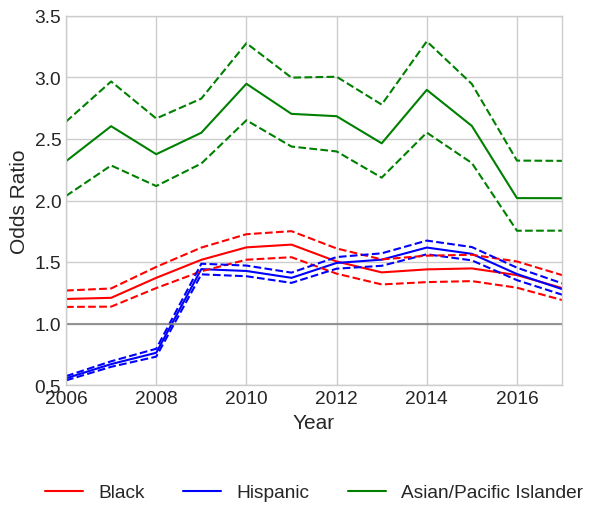

***********************************
2006
Capital
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Capital
# of traffic stops after preprocessing in year  2006 :  68085
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.684995
         

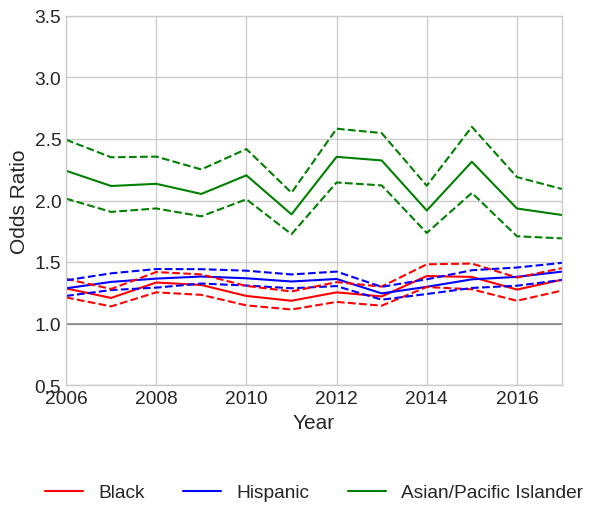

***********************************
2006
Central Texas 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Central Texas 
# of traffic stops after preprocessing in year  2006 :  92807
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
  

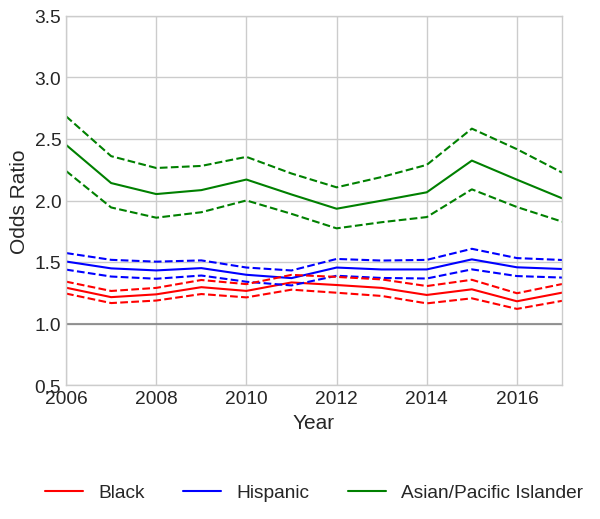

***********************************
2006
Gulf Coast 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Gulf Coast 
# of traffic stops after preprocessing in year  2006 :  114368
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
       

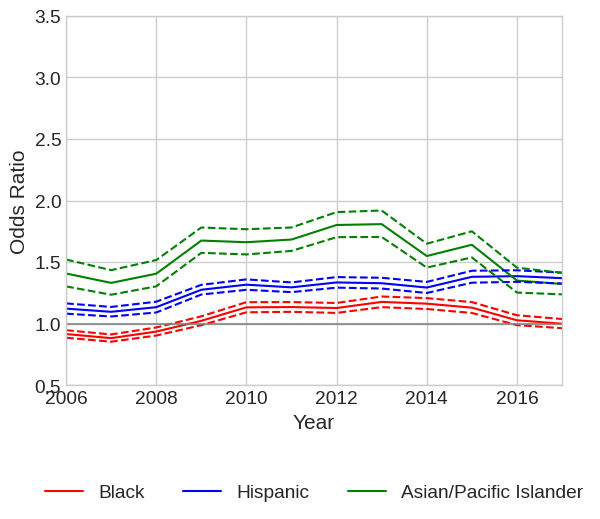

***********************************
2006
High Plains 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  High Plains 
# of traffic stops after preprocessing in year  2006 :  116377
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
     

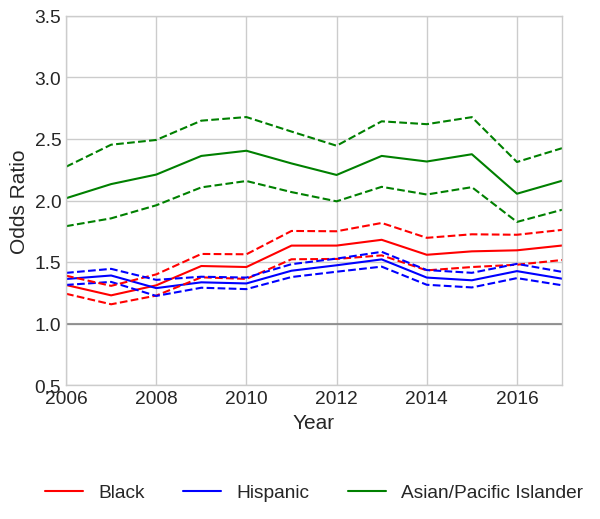

***********************************
2006
Metroplex 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Metroplex 
# of traffic stops after preprocessing in year  2006 :  162697
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 

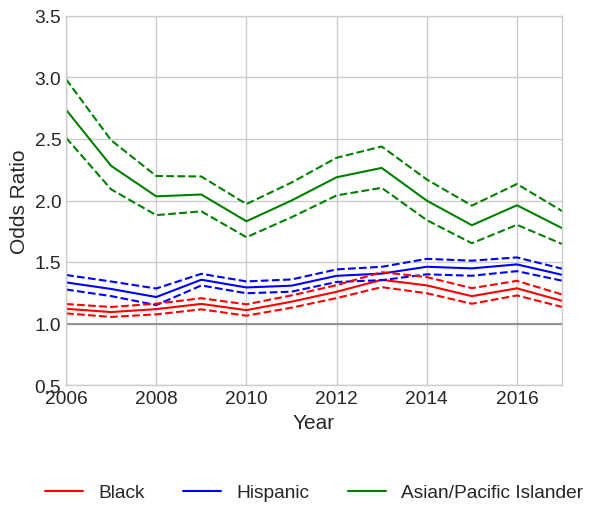

***********************************
2006
Northwest 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Northwest 
# of traffic stops after preprocessing in year  2006 :  110826
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         

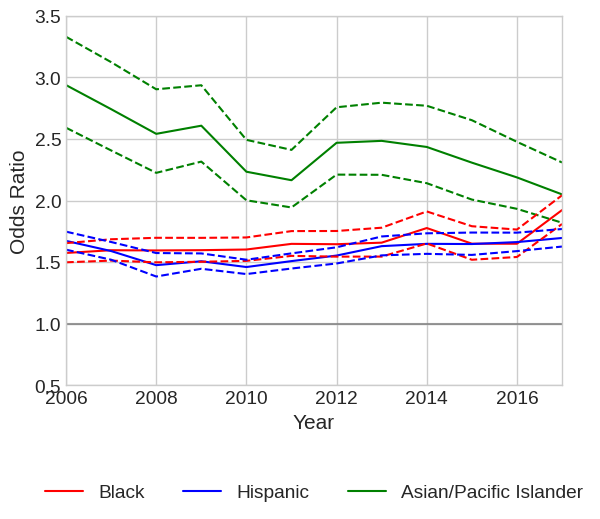

***********************************
2006
South Texas 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  South Texas 
# of traffic stops after preprocessing in year  2006 :  146286
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
     

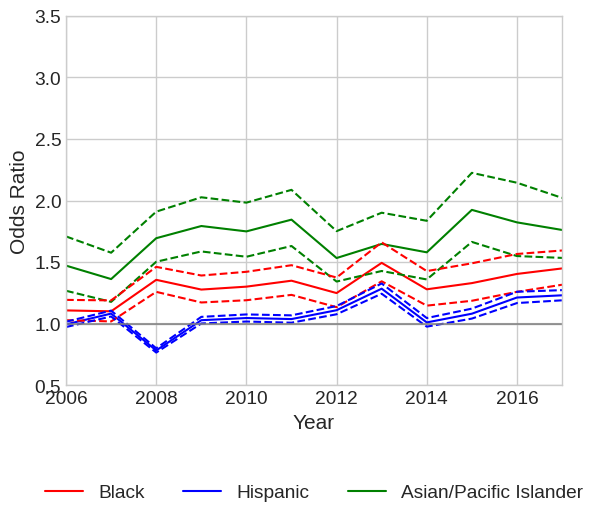

***********************************
2006
Southeast 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Southeast 
# of traffic stops after preprocessing in year  2006 :  59935
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         C

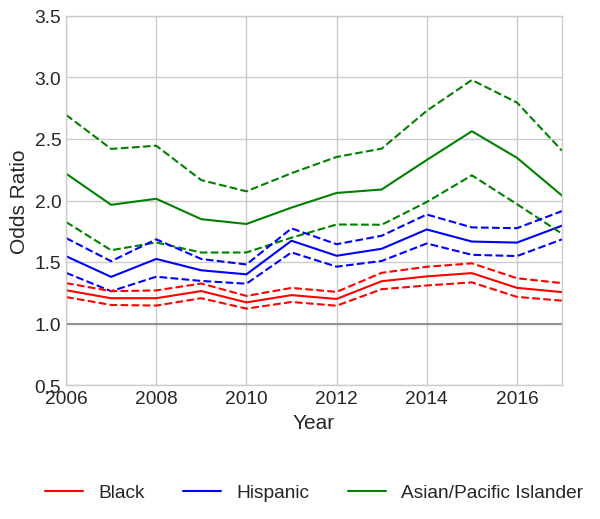

***********************************
2006
 Upper East 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:   Upper East 
# of traffic stops after preprocessing in year  2006 :  143767
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
     

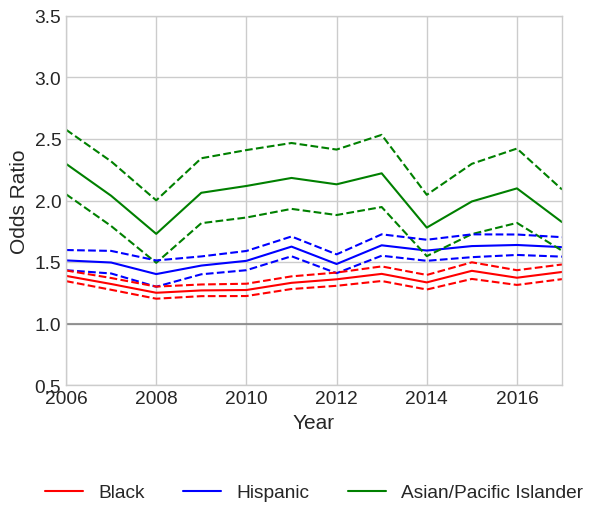

***********************************
2006
UPPER RIO GRANDE
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  UPPER RIO GRANDE
# of traffic stops after preprocessing in year  2006 :  27577
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 

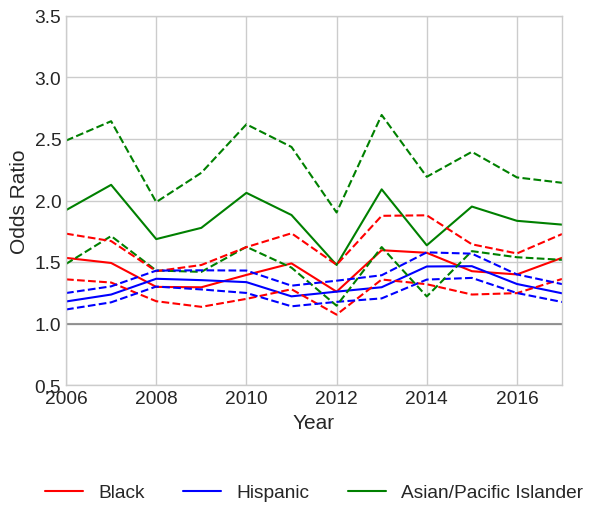

***********************************
2006
West Texas 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  West Texas 
# of traffic stops after preprocessing in year  2006 :  93124
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
        

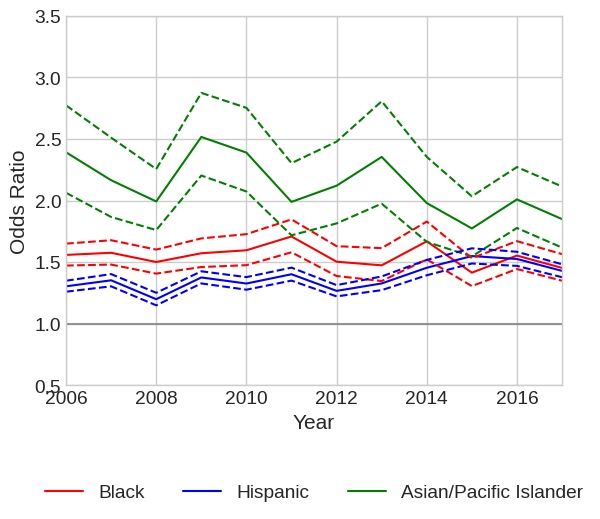

In [13]:
year_start = 2006
year_end = 2017

#folder_path ='/content/drive/MyDrive/traffic_stop/region_outputs/'
folder_path ='/content/drive/MyDrive/traffic_stop/y_region_outputs/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
for region in region_lst:
  asianpacific = []
  black = []
  hispanic = []

  asianpacific_low = []
  black_low = []
  hispanic_low = []

  asianpacific_high = []
  black_high = []
  hispanic_high = []
  generate_outputs(folder_path=folder_path, analysis_type='citation', violation_types=None, border_counties=None, county_type=None, speeding_only=True, county_region=region)

### Speeding-only, Search

***********************************
2006
Alamo
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Alamo
# of traffic stops after preprocessing in year  2006 :  98279
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current fun

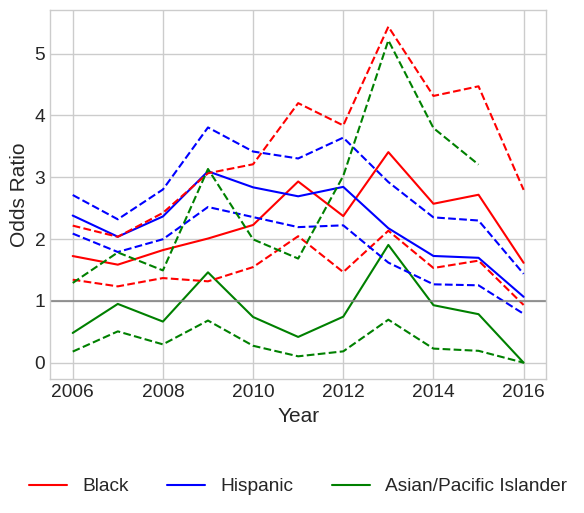

***********************************
2006
Capital
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Capital
# of traffic stops after preprocessing in year  2006 :  68085
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.031365
         

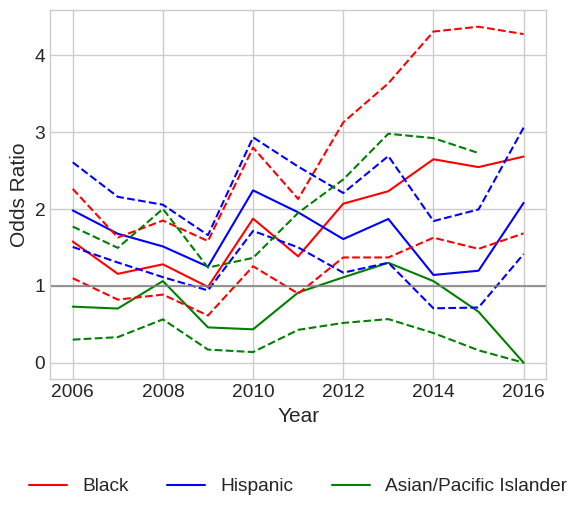

***********************************
2006
Central Texas 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Central Texas 
# of traffic stops after preprocessing in year  2006 :  92807
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
  

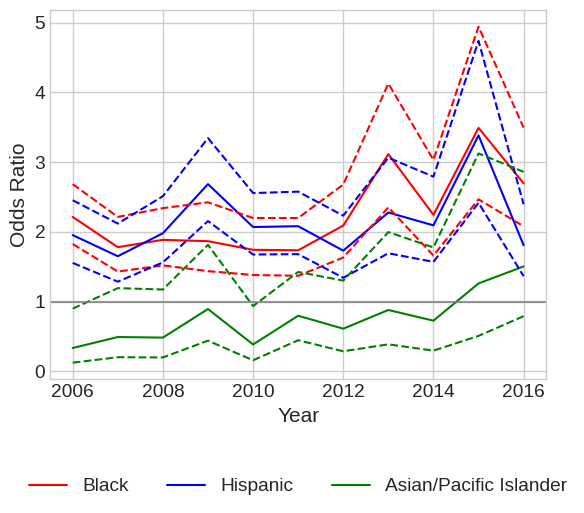

***********************************
2006
Gulf Coast 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Gulf Coast 
# of traffic stops after preprocessing in year  2006 :  114368
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
       

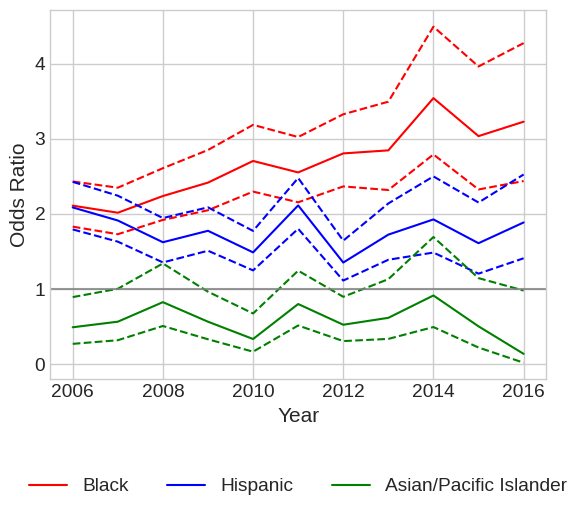

***********************************
2006
High Plains 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  High Plains 
# of traffic stops after preprocessing in year  2006 :  116377
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
     

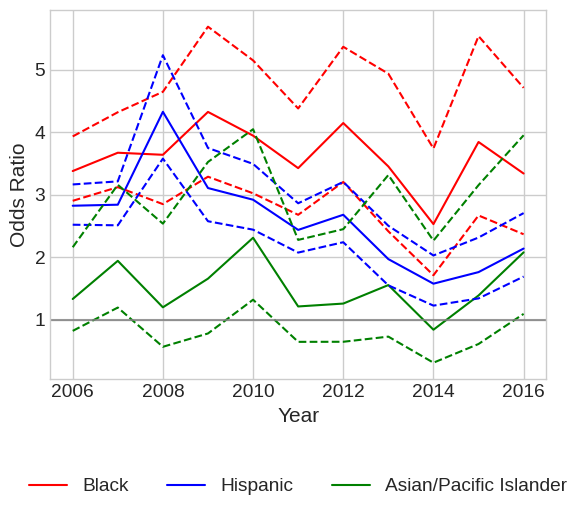

***********************************
2006
Metroplex 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Metroplex 
# of traffic stops after preprocessing in year  2006 :  162697
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 

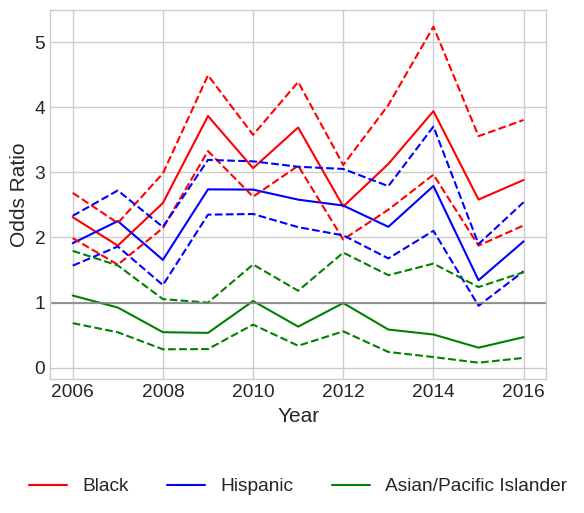

***********************************
2006
Northwest 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Northwest 
# of traffic stops after preprocessing in year  2006 :  110826
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         

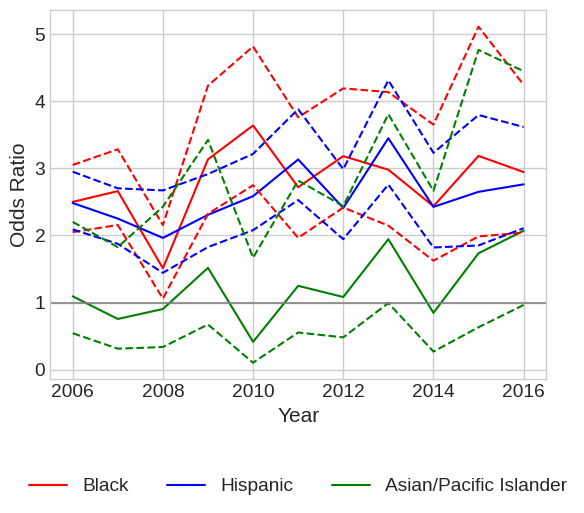

***********************************
2006
South Texas 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  South Texas 
# of traffic stops after preprocessing in year  2006 :  146286
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
     

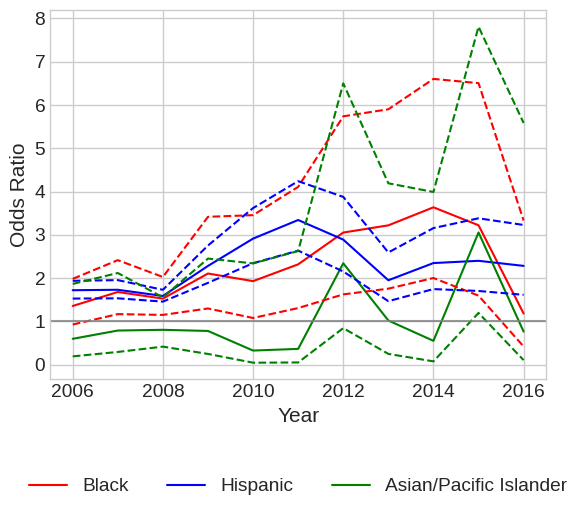

***********************************
2006
Southeast 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Southeast 
# of traffic stops after preprocessing in year  2006 :  59935
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         C

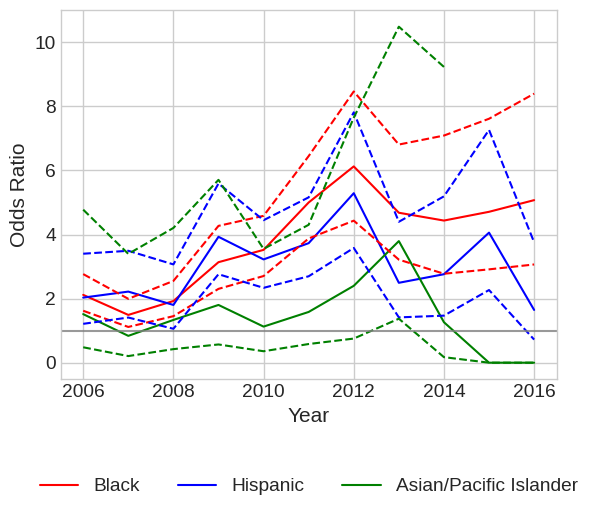

***********************************
2006
 Upper East 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:   Upper East 
# of traffic stops after preprocessing in year  2006 :  143767
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
     

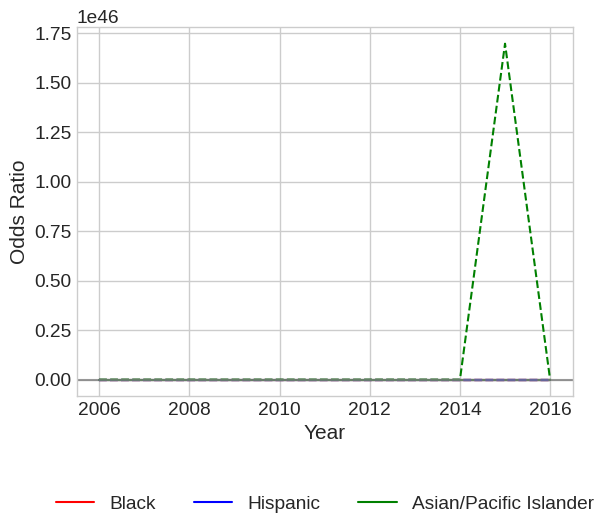

***********************************
2006
UPPER RIO GRANDE
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  UPPER RIO GRANDE
# of traffic stops after preprocessing in year  2006 :  27577
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 

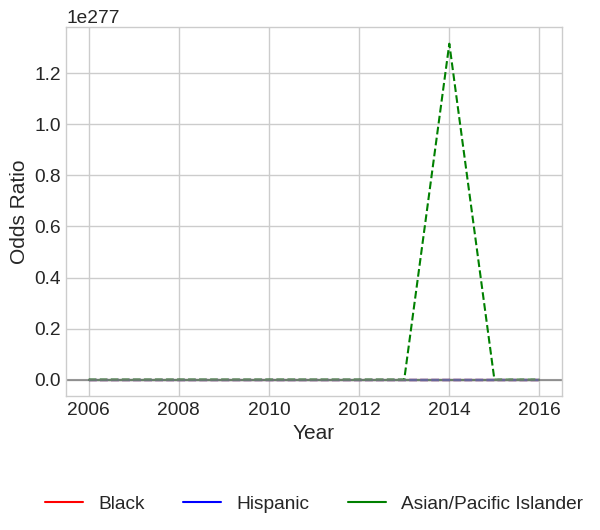

***********************************
2006
West Texas 
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  West Texas 
# of traffic stops after preprocessing in year  2006 :  93124
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
        

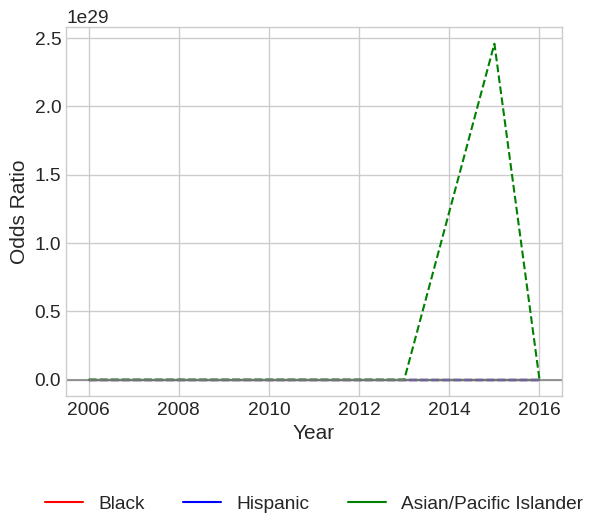

In [37]:
year_start = 2006
year_end = 2016

folder_path ='/content/drive/MyDrive/traffic_stop/region_outputs/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
for region in region_lst:
  asianpacific = []
  black = []
  hispanic = []

  asianpacific_low = []
  black_low = []
  hispanic_low = []

  asianpacific_high = []
  black_high = []
  hispanic_high = []
  generate_outputs(folder_path=folder_path, analysis_type='search', violation_types=None, border_counties=None, county_type=None, speeding_only=True, county_region=region)

### Speeding-only, Contraband

In [38]:
year_start = 2006
year_end = 2016

folder_path ='/content/drive/MyDrive/traffic_stop/region_outputs/'
#generate_outputs(folder_path = folder_path, with_vio = False, violation_types = None)
for region in region_lst:
  asianpacific = []
  black = []
  hispanic = []

  asianpacific_low = []
  black_low = []
  hispanic_low = []

  asianpacific_high = []
  black_high = []
  hispanic_high = []
  generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=None, county_type=None, speeding_only=True, county_region=region)

***********************************
2006
Alamo
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Alamo
# of traffic stops after preprocessing in year  2006 :  1004
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female',
       'county_type_Micropolitan', 'county_type_Non core'],
      dtype='object')
Optimization terminated successfully.
         Current func

LinAlgError: ignored

In [39]:
region_df['region'].unique()

array(['Alamo', 'Capital', 'Central Texas ', 'Gulf Coast ',
       'High Plains ', 'Metroplex ', 'Northwest ', 'South Texas ',
       'Southeast ', ' Upper East ', 'UPPER RIO GRANDE', 'West Texas '],
      dtype=object)

In [40]:
asianpacific = []
black = []
hispanic = []

asianpacific_low = []
black_low = []
hispanic_low = []

asianpacific_high = []
black_high = []
hispanic_high = []
generate_outputs(folder_path=folder_path, analysis_type='contraband', violation_types=None, border_counties=None, county_type=None, speeding_only=True, county_region='Capital')

***********************************
2006
Capital
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ county_name ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ violation ]:  2693894
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_race ]:  2673511
# of traffic stops after preprocessing step 0 - drop na/unknown in COL [ subject_sex ]:  2673511
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing step 1(add county type):  1235103
Including only an economic region:  Capital
# of traffic stops after preprocessing in year  2006 :  344
Index(['subject_race_asian/pacific islander', 'subject_race_black',
       'subject_race_hispanic', 'subject_sex_female', 'county_type_Non core'],
      dtype='object')
         Current function value: 0.318744
         Iterations: 35
*************************

LinAlgError: ignored

In [41]:
year_end

2016